# Image Cleaning

Writing image analysis algorithm for microscope images can become very challening due to the noise present in images. There are multiple sources for this noise. Many times the sample labelling is weak and sensor gain needs to be pushed up recover image signal. Other time, presense of a bright flourescence in one channel bleeds over to another and washes the other image. Or to capture images quickly, exposure time is reduced. 

Noise in itself isn't a big problem if we are not performing quantitative analysis from the images. Since I have to do that, I have seen that writing robust algorithms which work in presense of large image noise is often very challenging. So here I explore if I can use auto-encoder to clean microscope images and make my life easier while I design image processing algorithm.

My basic idea in this project is to use a deep learning model to clean microscope images. My deep learning model is based on convolutional autoencoders. To train the model I synthetically generate clean and noisy microscopic images. In image generation I try to synthesis features typically seen microscopic images. Then I distort these clean images considering theoritical optical model of the microscope and add noise to it. 

After training the model, I noticed that I was able to recover back clean images from very noisy images. Here is a sneak peak of some of the results. I am pretty amazed by how well the model was able to restore the noisy images back to the original clean image. 

![](https://raw.githubusercontent.com/mohakpatel/ImageCleaning/master/data/Results.png)

In [1]:
# Standard libraries
import numpy as np
import numpy.matlib
import tensorflow as tf
import scipy.io as sio
from scipy import ndimage
import time
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 

# My support code
import image_generation as imgen
from imshow3D import imshow3D
from model import ImageCleaner

## Synthetic Image Generation


### Theoretical true clean image
The first step in image generation is creating a general biological sample. This in itself is a very difficult task. How do you best represnt features of fluroscently labelled biological sample. 

I create sudo-biological sample by creating a clean 3D image with randomly seeded blobs of various size and shapes. The blobs are generated by a gaussian distribution of varying sigma in each direction. For example, here I will create a 64x64x64 volume and visualize in slice by slice from my custom 3D imageviewer based on ipywidgets. 

This is my theoretical true clean image, without any optical distortion or image noise. 

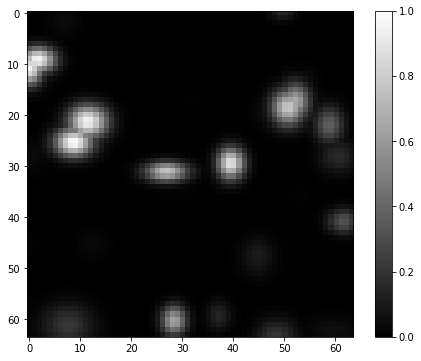

In [2]:
sizeI = np.array([64,64,64])
sigma_pts = {140:1.5*np.array([1,1,1]), 
            70:1.75*np.array([1,1,1]), 
            35:2*np.array([1,1,1])} # Number of particle and corresponding mean sigma
img = np.zeros(sizeI)

for nPts, sigma in sigma_pts.items():
    # Vary number of points and sigma
    nPts = np.round(np.random.poisson(nPts))
    pts = imgen.random_seed_locations(nPts, sizeI)
    sigma = (sigma + np.random.normal(0, 0.2*sigma[0], 
                        size=(nPts,3)))
    sigma = np.absolute(sigma)
    
    # Generate img
    img = np.maximum(imgen.seedBeadsN(pts, sizeI, sigma), img)

# Temporary visualize for Github notebook rendering
plt.figure(figsize=(8,6))
plt.imshow(img[:,:,0], cmap='gray', vmin=0, vmax=1)
plt.colorbar()

# Visuzlize using this on local computer. Commenting this because Github 
# does not show ipywidgets

# imshow3D(img)

### Blur Image with a PSF

Every optical system has its own point spread function (psf) which blurs the image captured by it. In this case, we simulate a psf from Born & Wolf 3D optical model, and blur the image with it. 

We can see that because of the psf, images lose their sharpness and it becomes more challending to segment neighboring blobs. This is also a true problem faced while segmenting neigboring small particles in microscope images

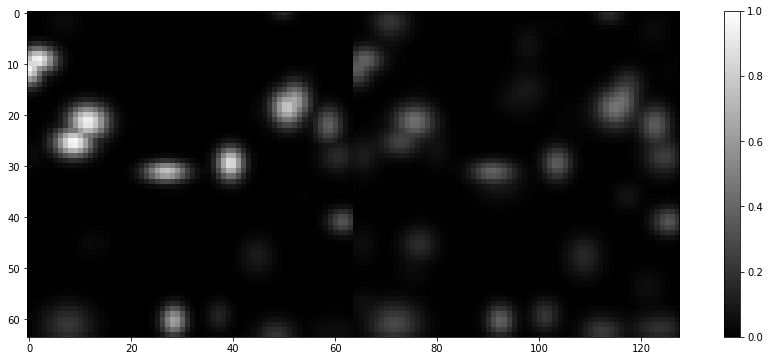

In [3]:
psf = sio.loadmat('../data/psf.mat')
psf = psf['psf']
psf = psf/np.sum(psf)


blurred_img = ndimage.convolve(img, psf, mode='constant', cval=0.0)

# Show the two images side-by side to visualize the original image (left) vs 
# blurring effect (right)

# Temporary visualize for Github notebook rendering
plt.figure(figsize=(16,6))
plt.imshow(np.squeeze(np.append(img[:,:,0], blurred_img[:,:,0], axis=1)), 
           cmap='gray', vmin=0, vmax=1)
plt.colorbar()

# Visuzlize using this on local computer. Commenting this because Github 
# does not show ipywidgets
# imshow3D(np.squeeze(np.append(img, blurred_img, axis=2)), 0, (12,12))

### Image intensity partial sensor range coverage

Moreover the image intensity does not cover the entire spread of the avaiable dynamic range in the sensor. We simulate this over here

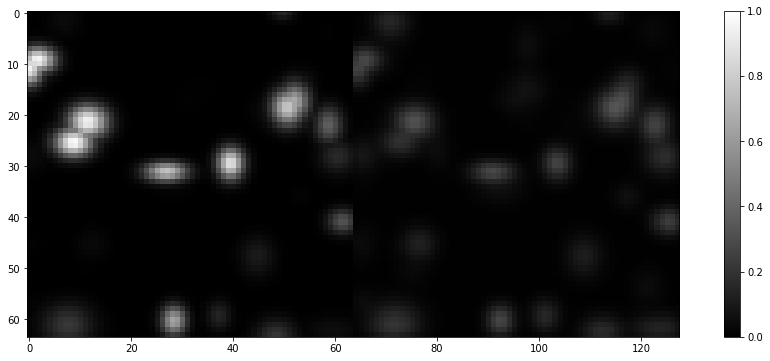

In [4]:
im_range = {'lower':0.2, 'upper':0.2, 'gap':0.6}

lower = np.random.random()*im_range['lower']
upper = np.random.random()*im_range['upper'] + im_range['gap']
range_img = imgen.change_im_range(blurred_img, lower, upper)

# Show the two images side-by side to visualize the original image (left) vs 
# the cropped sensor range image intensity coverage(right)

# Temporary visualize for Github notebook rendering
plt.figure(figsize=(16,6))
plt.imshow(np.squeeze(np.append(img[:,:,0], range_img[:,:,0], axis=1)), 
           cmap='gray', vmin=0, vmax=1)
plt.colorbar()

# Visuzlize using this on local computer. Commenting this because Github 
# does not show ipywidgets

# imshow3D(np.squeeze(np.append(img, range_img, axis=2)), 0, (12,12))

### Sensor shot noise

To generate the simulated images for each signal-to-noise ratio (SNr) from shot noise, we scale the image intensity such that the peak image intensity is equal to the SNr squared. Then each voxel intensity is replaced by a random number drawn from a Poisson’s distribution with its mean equal to the original intensity.

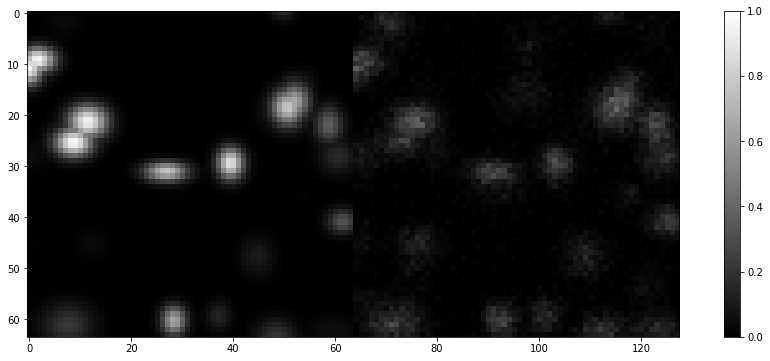

In [5]:
snr = 12
noise_img = imgen.add_poisson_noise(range_img, snr)

# Show the two images side-by side to visualize the original image (left) vs 
# image with sensor shot noise(right)

# Temporary visualize for Github notebook rendering
plt.figure(figsize=(16,6))
plt.imshow(np.squeeze(np.append(img[:,:,0], noise_img[:,:,0], axis=1)), 
           cmap='gray', vmin=0, vmax=1)
plt.colorbar()


# Visuzlize using this on local computer. Commenting this because Github 
# does not show ipywidgets

# imshow3D(np.squeeze(np.append(img, noise_img, axis=2)), 0, (12,12))

### Gaussian sensor noise

At last, we add gaussian noise to the image to simulate the usual gaussian noise present in any image. This is the last step in our synthetic noisy image generation. We can see how much different the noisy images are in comparison to the original images

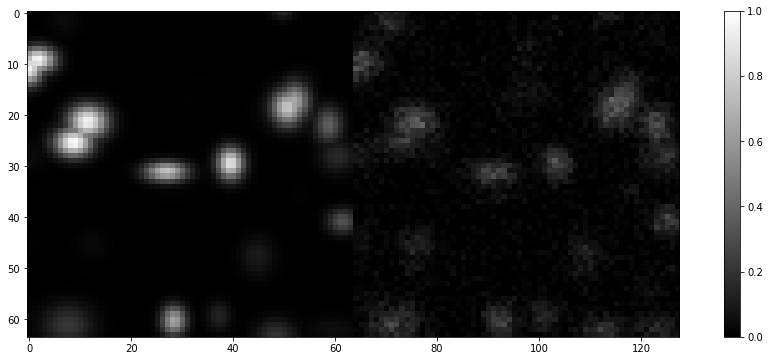

In [6]:
gauss_noise = {'mean':0, 'std':0.02}
noise_img = imgen.add_gaussian_noise(noise_img, gauss_noise['mean'], gauss_noise['std'])

# Show the two images side-by side to visualize the original image (left) vs 
# image with gaussian sensor noise(right)

# Temporary visualize for Github notebook rendering
plt.figure(figsize=(16,6))
plt.imshow(np.squeeze(np.append(img[:,:,0], noise_img[:,:,0], axis=1)), 
           cmap='gray', vmin=0, vmax=1)
plt.colorbar()

# Visuzlize using this on local computer. Commenting this because Github 
# does not show ipywidgets

# imshow3D(np.squeeze(np.append(img, noise_img, axis=2)), 0, (12,12))

### Synthetic dataset generation for training and test the model

Caution: This step takes time, so run it with some patience. On my computer it took about 13 seconds to generate 1000 images. 

I generate 27000 training images with 3000 test/validation images.

In [7]:
# Image generation parameters
n_images = 30000
slices = [x for x in range(14, 114, 5)]
sizeI = np.array([64,64,128])
sigmaPts = {280:1.5*np.array([1,1,1]), 140:1.75*np.array([1,1,1]), 70:2*np.array([1,1,1])}
im_range = {'lower':0.45, 'upper':0.45, 'gap':0.55}
gauss_noise = {'mean':0, 'std':0.01}
snr = 12
psf = sio.loadmat('../data/psf.mat')
psf = psf['psf']
psf = psf/np.sum(psf)

# Generate Images
start = time.time()
X_train, y_train = imgen.create_im_2D(n_images, sizeI, slices, sigmaPts, psf,snr=snr, 
                            im_range=im_range, gauss_noise=gauss_noise)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.10)
end = time.time()
print('Time elapsed in data generation: %0.3f seconds' % (end - start))

Time elapsed in data generation: 363.339 seconds


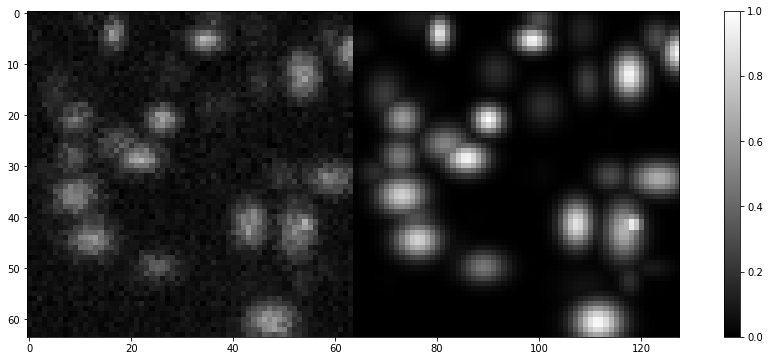

In [8]:
# Visualize synthetically generated images. Clean on left vs noisy on right

# Temporary visualize for Github notebook rendering
plt.figure(figsize=(16,6))
plt.imshow(np.squeeze(np.append(X_test[0,:,:,:], y_test[0,:,:,:], axis=1)), 
           cmap='gray', vmin=0, vmax=1)
plt.colorbar()

# Visuzlize using this on local computer. Commenting this because Github 
# does not show ipywidgets
# imshow3D(np.squeeze(np.append(X_train[:30,:,:,:], y_train[:30,:,:,:], axis=2)),
#          0, (12,12))

## Convolutional autoencoder model

I use a convolutional autoencoder model to recover back the original image from the noisy image. The model architecture can be seen in the figure below


I trained various models, and the model shown above gives the best accuracy scores. In the this model, I use three layers of convolution with relu activation to reduce the feature size from 64x64x1 to 8x8x45. Then I use four layers of transposed convolution with relue activatation to increase the feature size from 8x8x45 to 128x128x10. The I finally use a convolution layer coupled with sigmoid activation to recover the cleaned image. 

I minize the cross-entropy loss in training using Adam optimizer to train the model. 

![](https://raw.githubusercontent.com/mohakpatel/ImageCleaning/master/data/nnArtboard%201.png)

#### Evaluation parameter
In the model I define accuracy in terms of error. Here error is defined as the mean of absolute image intensity difference between noisy and the true clean image. 

In [9]:
# The model is implemented in model.py with Keras like api to fit, evaluate, predict, save and restore.
# This allows for clean training process over here. The model is however built using Tensorflow, and
# implemented with Keras/scikit-learn like api

model = ImageCleaner()
model.lr = 0.0001
model.dropout = 0.0

model.fit(x=X_train, 
          y=y_train, 
          epochs=200, 
          val_x=X_test, 
          val_y=y_test,
          save_path='./checkpoints/mymodel')


Epoch 1/200
27000/27000 [==============================] - 198s 7ms/step - Loss: 0.2931 - Error: 0.0491
Validation loss: 0.2754 - Validation Error: 0.0309
Epoch 2/200
27000/27000 [==============================] - 199s 7ms/step - Loss: 0.2745 - Error: 0.0289
Validation loss: 0.2730 - Validation Error: 0.0263
Epoch 3/200
27000/27000 [==============================] - 199s 7ms/step - Loss: 0.2730 - Error: 0.0261
Validation loss: 0.2729 - Validation Error: 0.0259
Epoch 4/200
27000/27000 [==============================] - 200s 7ms/step - Loss: 0.2721 - Error: 0.0245
Validation loss: 0.2722 - Validation Error: 0.0241
Epoch 5/200
27000/27000 [==============================] - 197s 7ms/step - Loss: 0.2717 - Error: 0.0235
Validation loss: 0.2714 - Validation Error: 0.0226
Epoch 6/200
27000/27000 [==============================] - 198s 7ms/step - Loss: 0.2712 - Error: 0.0225
Validation loss: 0.2711 - Validation Error: 0.0220
Epoch 7/200
27000/27000 [==============================] - 197s 7ms/st

27000/27000 [==============================] - 193s 7ms/step - Loss: 0.2689 - Error: 0.0167
Validation loss: 0.2692 - Validation Error: 0.0170
Epoch 106/200
27000/27000 [==============================] - 191s 7ms/step - Loss: 0.2689 - Error: 0.0168
Validation loss: 0.2694 - Validation Error: 0.0171
Epoch 107/200
27000/27000 [==============================] - 191s 7ms/step - Loss: 0.2689 - Error: 0.0167
Validation loss: 0.2694 - Validation Error: 0.0178
Epoch 108/200
27000/27000 [==============================] - 191s 7ms/step - Loss: 0.2689 - Error: 0.0167
Validation loss: 0.2693 - Validation Error: 0.0173
Epoch 109/200
27000/27000 [==============================] - 192s 7ms/step - Loss: 0.2689 - Error: 0.0168
Validation loss: 0.2693 - Validation Error: 0.0170
Epoch 110/200
27000/27000 [==============================] - 191s 7ms/step - Loss: 0.2689 - Error: 0.0167
Validation loss: 0.2694 - Validation Error: 0.0175
Epoch 111/200
27000/27000 [==============================] - 191s 7ms/st

### Visualize training loss and error

We can see that the validation loss and error is slightly higher than training cases. But the difference is very small, and we can assume that the model does not overfit. 

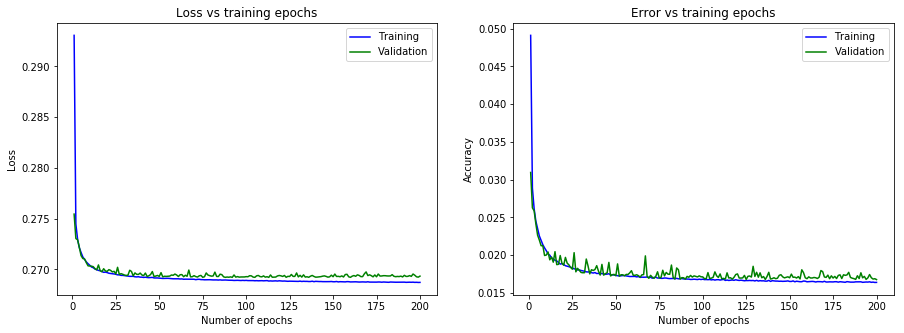

In [10]:
f, axs = plt.subplots(1,2,figsize=(15,5));

axs[0].plot(model.train_epoch, model.train_loss, 'b', label='Training')
axs[0].plot(model.train_epoch, model.val_loss, 'g', label='Validation')
axs[0].legend()
axs[0].set_title('Loss vs training epochs')
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Loss')

axs[1].plot(model.train_epoch, model.train_error, 'b', label='Training')
axs[1].plot(model.train_epoch, model.val_error, 'g', label='Validation')
axs[1].legend()
axs[1].set_title('Error vs training epochs')
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Accuracy');

## Save model for future

Save model for future use and restore it.

In [11]:
save_path = './final_model/my_model.ckpt'
model.save(save_path=save_path)

Model saved in path: ./final_model/my_model.ckpt


Restore saved model

In [12]:
save_path = './final_model/my_model.ckpt'

model = ImageCleaner()
model.restore(save_path=save_path)

INFO:tensorflow:Restoring parameters from ./final_model/my_model.ckpt
Model restored.


## Results

Lets visually look at some of the results and see how well did the model recover the orignial image from the noisy image. 

We can see that the results is quite remarkable. Model learnt pretty well how to denoise the synthetic images. The images are almost restored to their original self. Once in an while there is a very small difference, but it is honestly quite neglible. I'm very impressed with how well the model can recover images. 

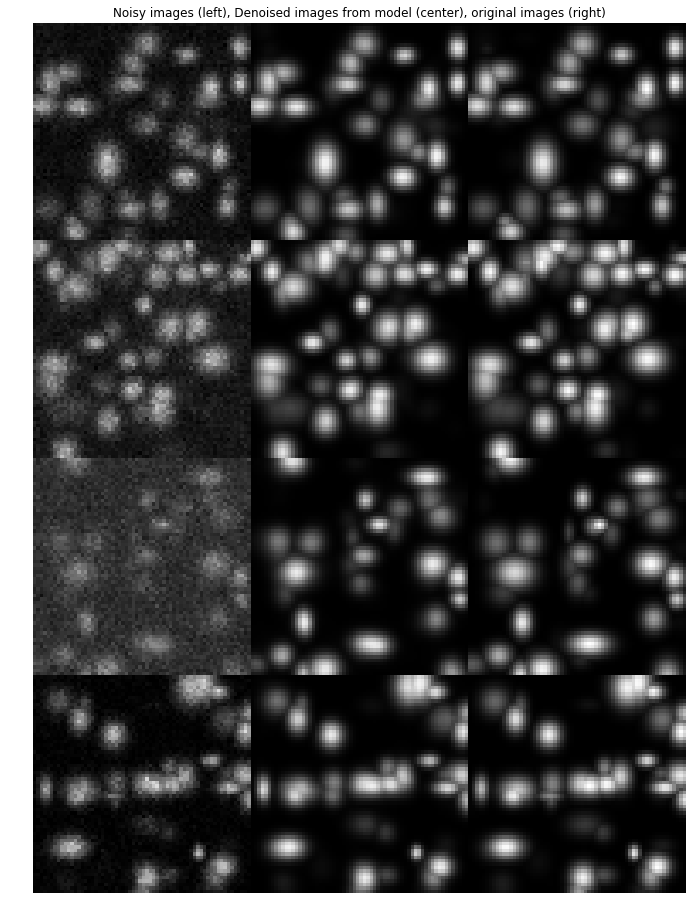

In [13]:
X_test, y_test = sklearn.utils.shuffle(X_test, y_test)
X_predict = model.predict(X_test, batch_size = 10)

n = 4
canvas = np.empty((64 * n, 64*3))
for i in range(n):
    # Draw the generated digits
    canvas[i*64 : (i+1)*64, 0:64] = np.squeeze(X_test[i,:,:,:])
    canvas[i*64 : (i+1)*64, 64:128] = np.squeeze(X_predict[i,:,:,:])
    canvas[i*64 : (i+1)*64, 128:192] = np.squeeze(y_test[i,:,:,:])

plt.figure(figsize=(12,4*n))
plt.imshow(canvas, cmap='gray', vmin=0, vmax=1)
plt.title('Noisy images (left), Denoised images from model (center), original images (right)')
plt.axis('off');

## Conclusion

We can see that convolutional auto-encoders are very powerful and can have significant uses in image cleaning. More sophisticated models can be built by training with real micrscope images, such that such techniques can be used in wild to deconvolve and clean microscope images. 